In [15]:
import sys
import math
import cv2 as cv
import numpy as np
from sympy import Point, Polygon
from sympy.geometry import Segment, Line
from matplotlib import pyplot as plt
%matplotlib inline

from pylab import rcParams

In [2]:
def loadImage(fileName):
    src = cv.imread(cv.samples.findFile(fileName), cv.IMREAD_GRAYSCALE)
    if src is None:
        print ('Error opening image!')
    plt.imshow(src)
    plt.show()
    return src

In [3]:
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv.cvtColor(labeled_img, cv.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    plt.imshow(labeled_img)
    plt.show()

In [20]:
def findComponents(image):
    edgyImg = cv.Canny(image, 50, 200, None, 3)
    edgyColor = cv.cvtColor(edgyImg, cv.COLOR_GRAY2BGR)
    
    DemoImg = np.zeros_like(edgyColor);
    
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(edgyImg);
    avg_height = 0;
    for stat in stats:
        avg_height += stat[cv.CC_STAT_HEIGHT]
    avg_height /= num_labels
    print ("Found " + str(num_labels) + " components with height " + str(avg_height) + " in image")
    
    if centroids is not None:
        for centroid in centroids:
            DemoImg[int(centroid[1]), int(centroid[0])] = [255,255,255]
    
    plt.imshow(DemoImg)
    plt.show()
    
    return (labels, avg_height, centroids, DemoImg)

In [21]:
def findHoughLines(centroidImg, outputImg, height):
    dst = cv.Canny(centroidImg, 50, 200, None, 3)
    cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
    
    lines = cv.HoughLines(dst, int(height), np.pi / 180, 50, None, 2,10)

    if lines is not None:
        print ("Calculated " + str(len(lines)) + " lines")
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            if (outputImg is None):
                cv.line(centroidImg, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
            else:
                cv.line(outputImg, pt1, pt2, (0,0,255), 3, cv.LINE_AA)

    if (outputImg is None):
        plt.imshow(centroidImg)
    else:
        plt.imshow(outputImg)
    plt.show()
    return lines;

In [57]:
def findSlope(x1, x2, x3, y1, y2, y3):
    return (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

def findLine(rho, theta):
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    
    return x1, x2, y1, y2

def findValueofcell(line, centroids):
    ntemp = 0
    
    x1, x2, y1, y2 = findLine(line[0][0], line[0][1])

    for pt in centroids:
        x3 = int(pt[0])
        y3 = int(pt[1])
        if (findSlope(x1, x2, x3, y1, y2, y3) == 0):
            ntemp +=1
    return ntemp
    
def findPrimaryCell(lines, centroids):
    n = 0
    lineP = (0,0);
    for line in lines:
        ntemp = findValueofcell(line, centroids)
        if (ntemp > n):
            lineP = line
            n = ntemp
    return lineP[0]

    
def findClustersize(theta, avg_height):
    theta = math.degrees(theta)
    if (theta > 85 and theta < 95):
        return 5
    else:
        return 2.5
    
def findPointsofRect(rho0, rho1, theta0, theta1):
    c0 = math.cos(theta0)
    s0 = math.sin(theta0)

    c1 = math.cos(theta1)
    s1 = math.sin(theta1)

    x0 = c0 * rho0
    y0 = s0 * rho0
    
    x1 = c1 * rho0
    y1 = s1 * rho0
    
    x2 = c0 * rho1
    y2 = s0 * rho1
    
    x3 = c1 * rho1
    y3 = s1 * rho1
    
    return [(x0,y0), (x1,y1), (x2,y2), (x3,y3)]

    
def findcells(x0, x1, z0, z1, lines):
    clusCells = []
    
    vertices = findPointsofRect(x0, x1, z0, z1);
    
    segment1 = Segment(vertices[0], vertices[1]);
    segment2 = Segment(vertices[1], vertices[2]);
    segment3 = Segment(vertices[2], vertices[3]);
    segment4 = Segment(vertices[3], vertices[0]);
    
    for line in lines:
        x1, x2, y1, y2 = findLine(line[0][0], line[0][1])
        lineF = Line((x1,y1),(x2,y2))
        
        i1 = lineF.intersection(segment1)
        i2 = lineF.intersection(segment2)
        i3 = lineF.intersection(segment3)
        i4 = lineF.intersection(segment4)
        
        if (not (len(i1) == 0 and len(i2) == 0 and len(i3) == 0 and len(i4) == 0)):
            clusCells.append(line)
    return clusCells
        

def compareValueinStruct(cell0, cell1, centroids, x0, x1, z0, z1, n0, n1):
    vertices = findPointsofRect(x0, x1, z0, z1);
    
    rect = Polygon(vertices[0], vertices[1], vertices[2], vertices[3])
    points = []
    
    for point in centroids:
        if (rect.encloses_point(point)):
            points.append(point)
    
    cell0V = findValueofcell(cell0, points)
    cell1V = findValueofcell(cell1, points)
    
    if ((n1/n0)>0.65 and cell1V>cell0V):
        return cell1[0]
    else:
        return cell0[0]
        
def houghDomainValidation(lines, centroids, avg_height):
    (rho_, theta_) = findPrimaryCell(lines, centroids)
    
    f_clus = findClustersize(theta_, avg_height)
    x0 = rho_ - f_clus
    x1 = rho_ + f_clus
    z0 = theta_ - math.radians(3)
    z1 = theta_ + math.radians(3)
    
    clusCells = findcells(x0, x1, z0, z1, lines)
    n0 = findValueofcell([(rho_, theta_)], centroids)
    
    ntemp = 0
    rho1, theta1 = 0,0
    for i in clusCells:
        temp = findValueofcell(i, centroids)
        if (temp > ntemp):
            ntemp = temp
            rho1 = i[0][0]
            theta1 = i[0][1]
    
    (rho_, theta_) = compareValueinStruct([(rho_, theta_)], [(rho1, theta1)], centroids, x0, x1, z0, z1, n0, ntemp)

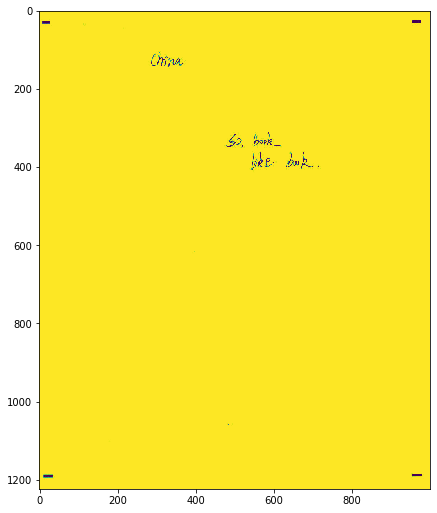

Found 43 components with height 40.58139534883721 in image


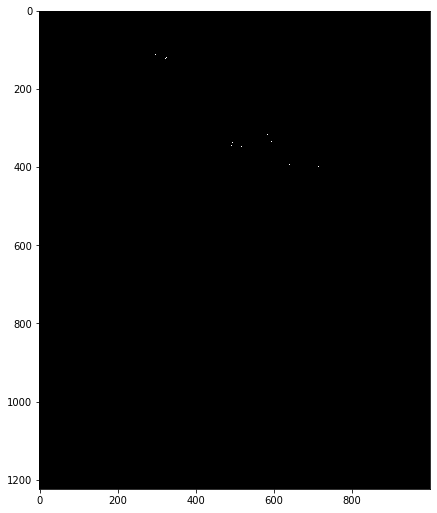

Calculated 84 lines


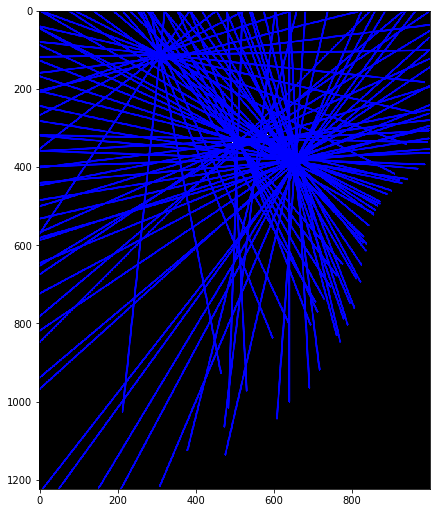

In [30]:
rcParams['figure.figsize'] = 7, 14

image = loadImage("222.jpg")
labels, avg_height, centroids, DemoImg = findComponents(image)
lines = findHoughLines(DemoImg, None, avg_height)

In [59]:
print (houghDomainValidation(lines, centroids, avg_height))

None


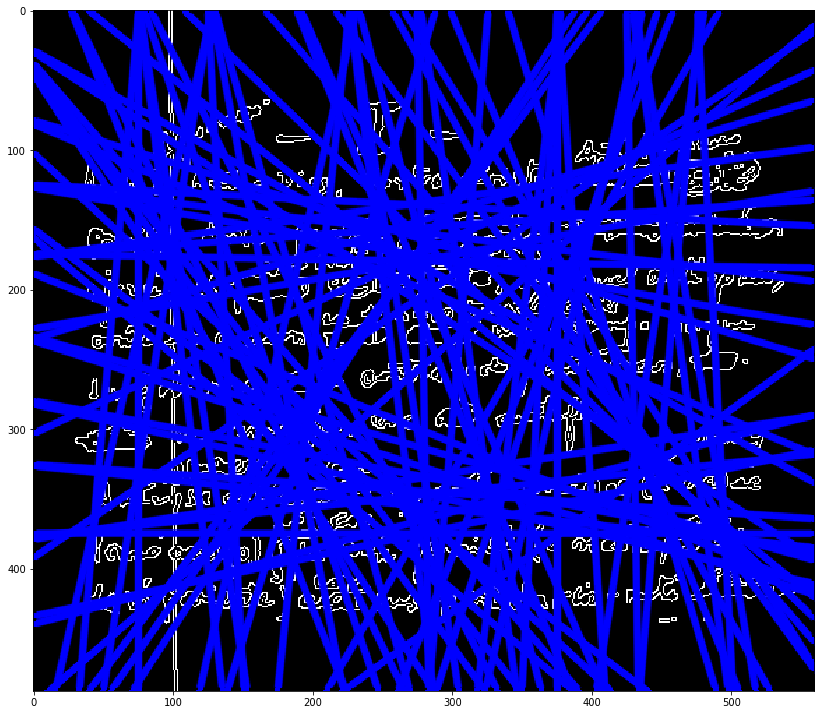

In [65]:
dst = cv.Canny(src, 50, 200, None, 3)
# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv.HoughLines(dst, 50, np.pi / 180, 150, None, 400, 30)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)

plt.imshow(cdst)
plt.show()

# How to choose:
# Threshold: number of points to fall on line before it is declared line
# Minimum length of line
# Maximum distanace between line

# How to validate a line
# Measuring nearest distance between centroid and line: 
#     but how to decide what is the line set for choice
# If external neighbors is greater than the number of internal ones:
#     don't understand how this will work

In [10]:
def findHoughLinesP(centroidImg, outputImg, height):
    dst = cv.Canny(centroidImg, 50, 200, None, 3)
    cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
    
    linesP = cv.HoughLinesP(dst, int(height), np.pi / 180, 100, None, 50, 50)

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            if (outputImg is None):
                cv.line(centroidImg, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
            else:
                cv.line(outputImg, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

    if (outputImg is None):
        plt.imshow(centroidImg)
    else:
        plt.imshow(outputImg)
    plt.show()
    return lines;

In [14]:
len([])

0

In [28]:
not 1==1

False